## Side Project - Flag illegal listings in Paris Airbnb dataset 

&rarr; **Dataset**: AirBnb data pertaining to paris Paris 

&rarr; **Source:** http://insideairbnb.com/get-the-data.html

&rarr; **Scenario**: Legal issues arising from listings exceeding the yearly 120 nights cap set by the government.

&rarr; **Task**: Flagging illegal listings in Paris Airbnb dataset

The files with Airbnb listings, calender and neighborhoods are available for analysis.

##### Motivation -

According to Critics, Airbnb drives up rental prices and lowers housing availability in cities such as Paris and San Francisco, forcing lawmakers to enact laws to protect the interests of local residents seeking accomodation. Failure to comply attracts heavy penalties, and any controversies triggered henceforth, can tarnish the public image of the company, and negatively impact customer affinity. 

##### Context of study -

Legal issues - Airbnb has been raking hefty fines for illegal rentals across the world, forcing lawmakers to coin newer laws. Specifically, in the city of Paris, Airbnb amassed fines of over 14 million Euros, thanks to a 2018 law that renders illegal posting (above 120 nights per year) punishable at 12,500 Euros per posting. 

###### Assumptions -

&rarr; As booking data is confidential, the listing was considered booked when it is unavailable based on ‘Availability_365 field (e.g. ‘False’) in Calendar file.

&rarr; ‘Adjusted Price’ in Calendar file was considered an accurate estimator of daily income over ‘Price’, as it probably incorporates offers and demand-based Smart-pricing.

&rarr; We are deeming listings based on a single criterion of yearly 120 nights as Illegal/Legal and chose to ignore other regulations for ease of study. 

&rarr; We considered the current dataset from Feb’19 to Jan’20 as yearly data irrespective of calendar year. 


Airbnb has been heavily penalized (€14 million fine last year) for listings that exceed the 120 nights per year legal limit. In this section, a statistical study was followed by visualizations isolating the illegal entities and their corresponding revenue.


In [1]:
# Initial import step
import datashader as ds
import datashader.transfer_functions as tf
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9, Hot, inferno, viridis
from datashader.bokeh_ext import InteractiveImage
from bokeh.plotting import figure, output_notebook, show
from datashader.bokeh_ext import InteractiveImage
from bokeh.tile_providers import STAMEN_TERRAIN
from bokeh.models import BoxZoomTool
from bokeh.layouts import row,column, gridplot, layout
from colorcet import fire
import pandas as pd
import math

%matplotlib inline

#### Data Pre-processing

In [2]:
# Create three dataframes selecting only the relevant data
listing = pd.read_csv('Data/listings.csv', usecols= \
            ['id', 'name', 'host_id', 'host_name','host_is_superhost','price','neighbourhood_cleansed','zipcode',\
             'latitude','longitude','property_type','room_type','smart_location','room_type','guests_included',\
             'accommodates','bathrooms','bedrooms','beds','bed_type','amenities','street','listing_url',\
             'review_scores_value','review_scores_rating','description','picture_url'])
neighbor = pd.read_csv('Data/neighbourhoods.csv')
calendar = pd.read_csv('Data/calendar.csv')

# View the dataframe with listings
listing.head()

C:\Users\megha\Anaconda3_new\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


id                        listing_url                               name  \
0  2577  https://www.airbnb.com/rooms/2577   Loft for 4 by Canal Saint Martin   
1  5396  https://www.airbnb.com/rooms/5396     Explore the heart of old Paris   
2  7397  https://www.airbnb.com/rooms/7397   MARAIS - 2ROOMS APT - 2/4 PEOPLE   
3  7964  https://www.airbnb.com/rooms/7964  Large & sunny flat with balcony !   
4  8522  https://www.airbnb.com/rooms/8522            GREAT FLAT w/ CITY VIEW   

                                         description  \
0  100 m2 loft (1100 sq feet) with high ceiling, ...   
1  Cozy, well-appointed and graciously designed s...   
2  VERY CONVENIENT, WITH THE BEST LOCATION ! PLEA...   
3  Very large & nice apartment all for you!  - Su...   
4  Really nice flat located in the 20th district ...   

                                         picture_url  host_id host_name  \
0  https://a0.muscache.com/im/pictures/09da057c-0...     2827    Karine   
1  https://a0.muscache.com/im/pictures/52413/f9bf...     7903    Borzou   
2  https://a0.muscache.com/im/pictures/67928287/3...     2626    Franck   
3  https://a0.muscache.com/im/pictures/4471349/6f...    22155     Anaïs   
4  https://a0.muscache.com/im/pictures/30560/0876...    25435    Adrien   

  host_is_superhost                        street neighbourhood_cleansed  \
0                 f  Paris, Île-de-France, France               Entrepôt   
1                 f  Paris, Ile-de-France, France         Hôtel-de-Ville   
2                 t  Paris, Île-de-France, France         Hôtel-de-Ville   
3                 f  Paris, Île-de-France, France                  Opéra   
4                 f  Paris, Ile-de-France, France           Ménilmontant   

          ...          accommodates bathrooms  bedrooms  beds       bed_type  \
0         ...                     4       2.0       2.0   2.0       Real Bed   
1         ...                     2       1.0       0.0   1.0  Pull-out Sofa   
2         ...                     4       1.0       2.0   2.0       Real Bed   
3         ...                     2       1.0       2.0   2.0       Real Bed   
4         ...                     3       1.0       1.0   1.0       Real Bed   

                                           amenities    price  \
0  {TV,Internet,Wifi,Kitchen,Heating,Washer,Dryer...  $125.00   
1  {TV,"Cable TV",Internet,Wifi,Kitchen,Heating,W...  $115.00   
2  {TV,"Cable TV",Internet,Wifi,Kitchen,"Paid par...  $115.00   
3  {TV,"Cable TV",Internet,Wifi,Kitchen,"Buzzer/w...   $99.00   
4  {Internet,Wifi,Kitchen,"Washer / Dryer",Elevat...   $90.00   

   guests_included  review_scores_rating  review_scores_value  
0                1                 100.0                 10.0  
1                1                  93.0                  9.0  
2                2                  94.0                 10.0  
3                2                  96.0                 10.0  
4                1                 100.0                  NaN  

[5 rows x 26 columns]

In [3]:
# View the dataframes with the calendar
calendar.head()

listing_id        date available    price adjusted_price  minimum_nights  \
0        2577  2019-02-05         f  $125.00        $125.00             3.0   
1        2577  2019-02-06         f  $125.00        $125.00             3.0   
2        2577  2019-02-07         f  $125.00        $125.00             3.0   
3        2577  2019-02-08         f  $125.00        $125.00             3.0   
4        2577  2019-02-09         f  $125.00        $125.00             3.0   

   maximum_nights  
0          1125.0  
1          1125.0  
2          1125.0  
3          1125.0  
4          1125.0

In [4]:
# Check if price and adjusted_price are same
check = calendar['price'] == calendar['adjusted_price']
print (check.value_counts(),'\n\n')
calendar.info()

True     21167749
False       27415
dtype: int64 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21195164 entries, 0 to 21195163
Data columns (total 7 columns):
listing_id        int64
date              object
available         object
price             object
adjusted_price    object
minimum_nights    float64
maximum_nights    float64
dtypes: float64(2), int64(1), object(4)
memory usage: 1.1+ GB


In [5]:
# Convert price and adjusted price to integar by removing $ symbol

# calendar['price'] = [int(x.replace('$',''))for x in calendar['price']]
calendar['price'] = calendar.price.replace('[\$,)]','', regex=True).astype(float)
calendar['adjusted_price'] = calendar.adjusted_price.replace('[\$,)]','', regex=True).astype(float)
calendar.info()

# We will do the same for the price field in listing
listing['price'] = listing.price.replace('[\$,)]','', regex=True).astype(float)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21195164 entries, 0 to 21195163
Data columns (total 7 columns):
listing_id        int64
date              object
available         object
price             float64
adjusted_price    float64
minimum_nights    float64
maximum_nights    float64
dtypes: float64(4), int64(1), object(2)
memory usage: 1.1+ GB


In [6]:
# View the dataframes with the neighborhood data
neighbor.head()

neighbourhood_group        neighbourhood
0                  NaN  Batignolles-Monceau
1                  NaN               Bourse
2                  NaN      Buttes-Chaumont
3                  NaN    Buttes-Montmartre
4                  NaN               Élysée

In [7]:
# Remove the unwanted column from the above dataframe
print (neighbor.info())
neighbor.drop('neighbourhood_group', axis=1, inplace = True)
neighbor.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
neighbourhood_group    0 non-null float64
neighbourhood          20 non-null object
dtypes: float64(1), object(1)
memory usage: 400.0+ bytes
None


neighbourhood
0  Batignolles-Monceau
1               Bourse
2      Buttes-Chaumont
3    Buttes-Montmartre
4               Élysée

#### Booking details

Due to the absence of booking data, possibly due to confidentiality of trade secrets, we are assuming that the listing is booked when it is not available for booking, i.e, when availability is False.

We will further filter down to visualize the count per listing and revenue generated.

In [8]:
# Filter and find the booking count and revenue generated
Filtered = calendar[calendar['available']=='f']

Count = Filtered.groupby('listing_id')['adjusted_price'].count()
Revenue = Filtered.groupby('listing_id')['adjusted_price'].sum()

In [9]:
# Merge all the relevant fields and perform data manipulations
Book = []; Booked=[];    #To prevent errors while re-executing code
Book = Count.to_frame().merge(Revenue.to_frame(), left_on='listing_id', right_index=True)
Book.rename({'adjusted_price_x':'Days' , 
               'adjusted_price_y': 'Total_revenue'}, axis='columns', inplace=True)
Book.reset_index(level=0, inplace=True)
Book.head()

listing_id  Days  Total_revenue
0        2577   280        35000.0
1        5396   236        27748.0
2        7397   154        17215.0
3        7964   146        14454.0
4        9359    24         1800.0

In [10]:
# Further merge and filter down and fields unnecessary for geographical plotting
Book = pd.merge(Book, calendar, on='listing_id', how='inner')
print (Book.head())
Booked = Book.drop_duplicates('listing_id')
Booked.reset_index(drop=True, inplace=True)
Booked.drop(columns=['date','price','minimum_nights','maximum_nights'], inplace=True)
Booked.rename ({"adjusted_price": "Daily_price"},axis='columns',inplace=True)
Booked.head()

   listing_id  Days  Total_revenue        date available  price  \
0        2577   280        35000.0  2019-02-05         f  125.0   
1        2577   280        35000.0  2019-02-06         f  125.0   
2        2577   280        35000.0  2019-02-07         f  125.0   
3        2577   280        35000.0  2019-02-08         f  125.0   
4        2577   280        35000.0  2019-02-09         f  125.0   

   adjusted_price  minimum_nights  maximum_nights  
0           125.0             3.0          1125.0  
1           125.0             3.0          1125.0  
2           125.0             3.0          1125.0  
3           125.0             3.0          1125.0  
4           125.0             3.0          1125.0  


C:\Users\megha\Anaconda3_new\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\megha\Anaconda3_new\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


listing_id  Days  Total_revenue available  Daily_price
0        2577   280        35000.0         f        125.0
1        5396   236        27748.0         f         79.0
2        7397   154        17215.0         f         95.0
3        7964   146        14454.0         f         99.0
4        9359    24         1800.0         f         75.0

In [11]:
# Find the legal and illegal days of booking per listing
Booked['Legal_days'] = [120 if x>120 else x for x in Booked.Days]
Booked['Illegal_days'] = Booked.apply(lambda x: x['Days'] - x['Legal_days'], axis=1)
Booked.head()

C:\Users\megha\Anaconda3_new\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\megha\Anaconda3_new\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


listing_id  Days  Total_revenue available  Daily_price  Legal_days  \
0        2577   280        35000.0         f        125.0         120   
1        5396   236        27748.0         f         79.0         120   
2        7397   154        17215.0         f         95.0         120   
3        7964   146        14454.0         f         99.0         120   
4        9359    24         1800.0         f         75.0          24   

   Illegal_days  
0           160  
1           116  
2            34  
3            26  
4             0

In [12]:
# Find the legal and illegal yearly revenue per listing and merge with the listing dataframe
Booked['Legal_revenue'] = Booked.apply(lambda x: x['Legal_days'] * x['Daily_price'], axis=1)
Booked['Illegal_revenue'] = Booked.apply(lambda x: x['Total_revenue'] - x['Legal_revenue'], axis=1)
Booked = pd.merge(Booked,listing, left_on='listing_id', right_on='id', suffixes=(False, False))
Booked.head()

C:\Users\megha\Anaconda3_new\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\megha\Anaconda3_new\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


listing_id  Days  Total_revenue available  Daily_price  Legal_days  \
0        2577   280        35000.0         f        125.0         120   
1        5396   236        27748.0         f         79.0         120   
2        7397   154        17215.0         f         95.0         120   
3        7964   146        14454.0         f         99.0         120   
4        9359    24         1800.0         f         75.0          24   

   Illegal_days  Legal_revenue  Illegal_revenue    id         ...          \
0           160        15000.0          20000.0  2577         ...           
1           116         9480.0          18268.0  5396         ...           
2            34        11400.0           5815.0  7397         ...           
3            26        11880.0           2574.0  7964         ...           
4             0         1800.0              0.0  9359         ...           

  accommodates bathrooms bedrooms beds       bed_type  \
0            4       2.0      2.0  2.0       Real Bed   
1            2       1.0      0.0  1.0  Pull-out Sofa   
2            4       1.0      2.0  2.0       Real Bed   
3            2       1.0      2.0  2.0       Real Bed   
4            2       1.0      1.0  1.0       Real Bed   

                                           amenities  price guests_included  \
0  {TV,Internet,Wifi,Kitchen,Heating,Washer,Dryer...  125.0               1   
1  {TV,"Cable TV",Internet,Wifi,Kitchen,Heating,W...  115.0               1   
2  {TV,"Cable TV",Internet,Wifi,Kitchen,"Paid par...  115.0               2   
3  {TV,"Cable TV",Internet,Wifi,Kitchen,"Buzzer/w...   99.0               2   
4  {Internet,Wifi,Kitchen,Elevator,Heating,Essent...   75.0               1   

  review_scores_rating review_scores_value  
0                100.0                10.0  
1                 93.0                 9.0  
2                 94.0                10.0  
3                 96.0                10.0  
4                  NaN                 NaN  

[5 rows x 35 columns]

In [13]:
# Rearrange the columns according to relevancy
Booked = Booked [['listing_id', 'Days', 'Total_revenue', 'available', 'Daily_price','Legal_days', 'Illegal_days', \
                 'Legal_revenue', 'Illegal_revenue','latitude','longitude','neighbourhood_cleansed','zipcode',\
                 'property_type','smart_location','room_type','name', 'host_id', 'host_name','host_is_superhost', \
                 'guests_included','accommodates','bathrooms','bedrooms','beds','bed_type','amenities','street',\
                 'listing_url','review_scores_value','review_scores_rating','description','picture_url']]

# Create separate dataframes with legal and illegal listings
Legal = Booked[Booked['Illegal_days'] == 0]
Illegal = Booked[Booked['Illegal_days'] != 0]
print ("Total listings:", Booked.listing_id.count(),\
       "\nNo of legal listings based on the 120 nights yearly restriction:", Legal.listing_id.count(),\
       "\nNo of Illegal listings based on the 120 nights yearly restriction:", Illegal.listing_id.count(),"\n\n")
Legal.head()

Total listings: 57371 
No of legal listings based on the 120 nights yearly restriction: 8750 
No of Illegal listings based on the 120 nights yearly restriction: 48621 




listing_id  Days  Total_revenue available  Daily_price  Legal_days  \
4         9359    24         1800.0         f         75.0          24   
10       11213   120        18840.0         f        157.0         120   
12       11487    58         4060.0         f         70.0          58   
13       11798    19         1900.0         f        100.0          19   
18       14264    10          900.0         f         90.0          10   

    Illegal_days  Legal_revenue  Illegal_revenue   latitude  \
4              0         1800.0              0.0  48.858985   
10             0        18840.0              0.0  48.871096   
12             0         4060.0              0.0  48.863499   
13             0         1900.0              0.0  48.824046   
18             0          900.0              0.0  48.883151   

                          ...                          bedrooms beds  \
4                         ...                               1.0  1.0   
10                        ...                               1.0  3.0   
12                        ...                               NaN  1.0   
13                        ...                               1.0  1.0   
18                        ...                               1.0  1.0   

         bed_type                                          amenities  \
4        Real Bed  {Internet,Wifi,Kitchen,Elevator,Heating,Essent...   
10       Real Bed  {TV,Internet,Wifi,Kitchen,"Smoking allowed","P...   
12  Pull-out Sofa         {"Cable TV",Internet,Wifi,Kitchen,Heating}   
13       Real Bed  {TV,"Cable TV",Internet,Wifi,Kitchen,"Paid par...   
18       Real Bed  {TV,"Cable TV",Internet,Wifi,Kitchen,"Paid par...   

                          street                         listing_url  \
4   Paris, Île-de-France, France   https://www.airbnb.com/rooms/9359   
10  Paris, Île-de-France, France  https://www.airbnb.com/rooms/11213   
12  Paris, Ile-de-France, France  https://www.airbnb.com/rooms/11487   
13  Paris, Île-de-France, France  https://www.airbnb.com/rooms/11798   
18  Paris, Île-de-France, France  https://www.airbnb.com/rooms/14264   

   review_scores_value  review_scores_rating  \
4                  NaN                   NaN   
10                 9.0                  92.0   
12                 9.0                  94.0   
13                10.0                  98.0   
18                 9.0                  91.0   

                                          description  \
4   Location! Location! Location! Just bring your ...   
10  Numéro d'enregistrement Ville de Paris (Phone ...   
12  Brand new renovated studio with living room, b...   
13  Mon appartement est situé dans une très jolie ...   
18  Beautifully furnished 1-2 bedrooms spacious ap...   

                                          picture_url  
4   https://a0.muscache.com/im/pictures/c2965945-0...  
10  https://a0.muscache.com/im/pictures/48419/e691...  
12  https://a0.muscache.com/im/pictures/50213/7fab...  
13  https://a0.muscache.com/im/pictures/22458692/0...  
18  https://a0.muscache.com/im/pictures/11156748/8...  

[5 rows x 33 columns]

In [14]:
Illegal.head()

listing_id  Days  Total_revenue available  Daily_price  Legal_days  \
0        2577   280        35000.0         f        125.0         120   
1        5396   236        27748.0         f         79.0         120   
2        7397   154        17215.0         f         95.0         120   
3        7964   146        14454.0         f         99.0         120   
5        9952   165        12375.0         f         75.0         120   

   Illegal_days  Legal_revenue  Illegal_revenue   latitude  \
0           160        15000.0          20000.0  48.869933   
1           116         9480.0          18268.0  48.851001   
2            34        11400.0           5815.0  48.857576   
3            26        11880.0           2574.0  48.874642   
5            45         9000.0           3375.0  48.862266   

                         ...                          bedrooms beds  \
0                        ...                               2.0  2.0   
1                        ...                               0.0  1.0   
2                        ...                               2.0  2.0   
3                        ...                               2.0  2.0   
5                        ...                               1.0  1.0   

        bed_type                                          amenities  \
0       Real Bed  {TV,Internet,Wifi,Kitchen,Heating,Washer,Dryer...   
1  Pull-out Sofa  {TV,"Cable TV",Internet,Wifi,Kitchen,Heating,W...   
2       Real Bed  {TV,"Cable TV",Internet,Wifi,Kitchen,"Paid par...   
3       Real Bed  {TV,"Cable TV",Internet,Wifi,Kitchen,"Buzzer/w...   
5       Real Bed  {TV,Internet,Wifi,Kitchen,"Paid parking off pr...   

                         street                        listing_url  \
0  Paris, Île-de-France, France  https://www.airbnb.com/rooms/2577   
1  Paris, Ile-de-France, France  https://www.airbnb.com/rooms/5396   
2  Paris, Île-de-France, France  https://www.airbnb.com/rooms/7397   
3  Paris, Île-de-France, France  https://www.airbnb.com/rooms/7964   
5  Paris, Ile-de-France, France  https://www.airbnb.com/rooms/9952   

  review_scores_value  review_scores_rating  \
0                10.0                 100.0   
1                 9.0                  93.0   
2                10.0                  94.0   
3                10.0                  96.0   
5                10.0                  99.0   

                                         description  \
0  100 m2 loft (1100 sq feet) with high ceiling, ...   
1  Cozy, well-appointed and graciously designed s...   
2  VERY CONVENIENT, WITH THE BEST LOCATION ! PLEA...   
3  Very large & nice apartment all for you!  - Su...   
5  Make your stay in Paris a perfect experience. ...   

                                         picture_url  
0  https://a0.muscache.com/im/pictures/09da057c-0...  
1  https://a0.muscache.com/im/pictures/52413/f9bf...  
2  https://a0.muscache.com/im/pictures/67928287/3...  
3  https://a0.muscache.com/im/pictures/4471349/6f...  
5  https://a0.muscache.com/im/pictures/52474/aeb7...  

[5 rows x 33 columns]

In [15]:
# Number if all entries have information for georgraphical plotting
((Booked.longitude != 0) & (Booked.latitude != 0)).count()

57371

There seems to be no missing latitude and longitude entries in the dataset.


#### Formula for converting world co-ordinates to web mercator

Formulae for convertion to Web Mercator is similar to convertion to standard spherical Mercator. However,t before applying zoom, the "world coordinates" are adjusted such that the upper left corner is (0, 0) and the lower right corner is (256, 256):[8]

$${\displaystyle {\begin{aligned}x&={\frac {256}{2\pi }}2^{\text{zoom level}}(\lambda +\pi ){\text{ pixels}}\\y&={\frac {256}{2\pi }}2^{\text{zoom level}}\left(\pi -\ln \left[\tan \left({\frac {\pi }{4}}+{\frac {\varphi }{2}}\right)\right]\right){\text{ pixels}}\end{aligned}}}$$
where λ is the longitude in radians and φ is geodetic latitude in radians.

Because the Mercator projects the poles at infinity, Google Maps cannot show the poles. Instead it cuts off coverage at 85.051129° north and south. This is not considered a limitation, given the purpose of the service. The value 85.051129° is the latitude at which the full map becomes a square, and is computed as φ given y = 0:

$${\displaystyle {\begin{aligned}\varphi _{\text{max}}=\left[2\arctan(e^{\pi })-{\frac {\pi }{2}}\right]\end{aligned}}}$$

In [16]:
# Convert to web mercanator to view the changes for one of the dataframes

Booked["long"], Booked["lat"] = ds.utils.lnglat_to_meters(Booked["longitude"], Booked["latitude"])
Legal["long"], Legal["lat"] = ds.utils.lnglat_to_meters(Legal["longitude"], Legal["latitude"])
Illegal["long"], Illegal["lat"] = ds.utils.lnglat_to_meters(Illegal["longitude"], Illegal["latitude"])
Booked[["long", "longitude", "lat", "latitude"]].head()

C:\Users\megha\Anaconda3_new\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\megha\Anaconda3_new\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


long  longitude           lat   latitude
0  262993.481529   2.362511  6.252820e+06  48.869933
1  262568.215964   2.358690  6.249617e+06  48.851001
2  261907.077928   2.352751  6.250729e+06  48.857576
3  260867.331703   2.343411  6.253617e+06  48.874642
4  261305.497147   2.347347  6.250968e+06  48.858985

There are 57,371 entries to plot and visualize in this dataset.


### Define a simple plot


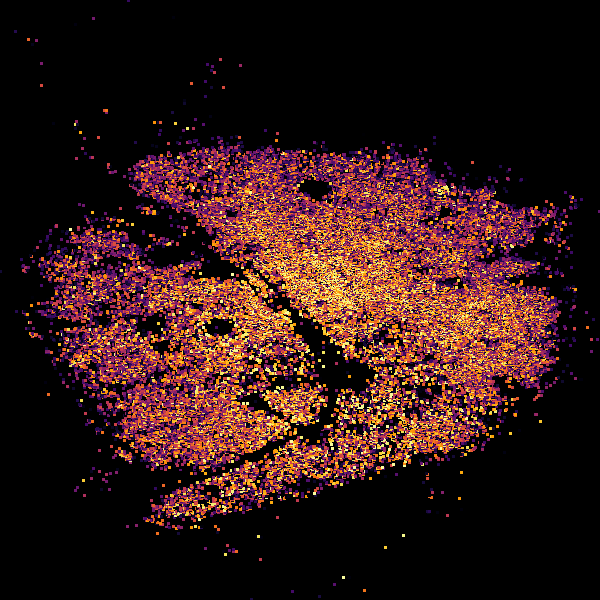
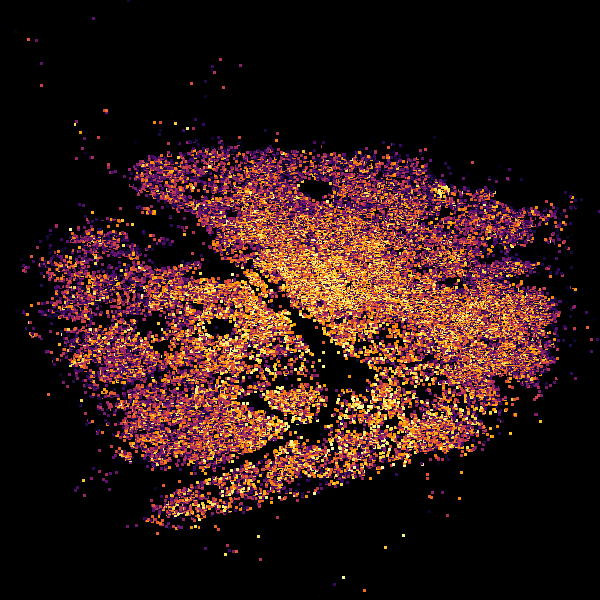
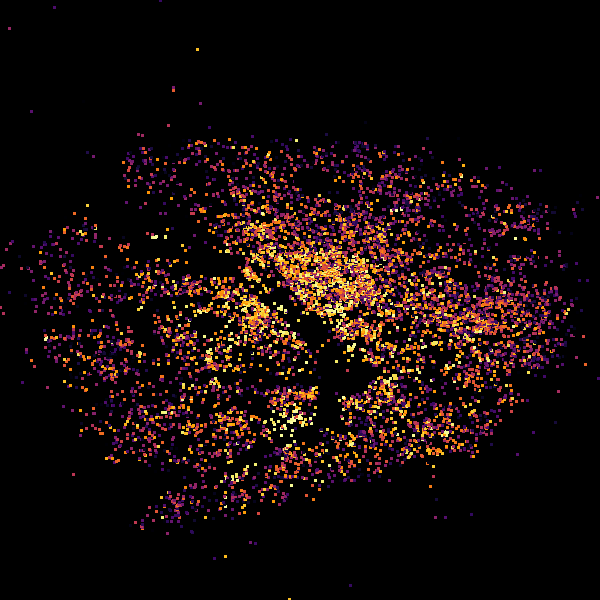

In [17]:
# Define a DataShader Canvas
cvs = ds.Canvas()
import matplotlib.pyplot as plt
# Total Revenue for all listings
agg_all = cvs.points(Booked, "lat", "long", ds.sum(column='Total_revenue'))

# Total Revenue for Illegal listings
agg_illegal = cvs.points(Illegal, "lat", "long", ds.sum(column='Total_revenue'))

# Total Revenue for Legal listings
agg_legal = cvs.points(Legal, "lat", "long", ds.sum(column='Total_revenue')) # Legal_revenue = Total_revenue

# Illegal revenue from Illegal listings
agg_IR_IL = cvs.points(Illegal, "lat", "long", ds.sum(column='Illegal_revenue'))

# Legal revenue from Illegal listings
agg_LR_IL = cvs.points(Illegal, "lat", "long", ds.sum(column='Legal_revenue'))

# Legal revenue from legal listings
agg_LR_LL = cvs.points(Legal, "lat", "long", ds.sum(column='Legal_revenue'))


tf.Images(tf.set_background(tf.dynspread(tf.shade(agg_all, cmap=inferno, \
                                         name='Total revenue from all Listings')),"black"),\
          tf.set_background(tf.dynspread(tf.shade(agg_illegal, cmap=inferno, \
                                         name='Total revenue from Illegal Listings')),"black"),\
          tf.set_background(tf.dynspread(tf.shade(agg_legal, cmap=inferno, \
                                         name='Total revenue from Legal Listings')),"black"))

Below analysis is more detailed and incorporated in the final report.


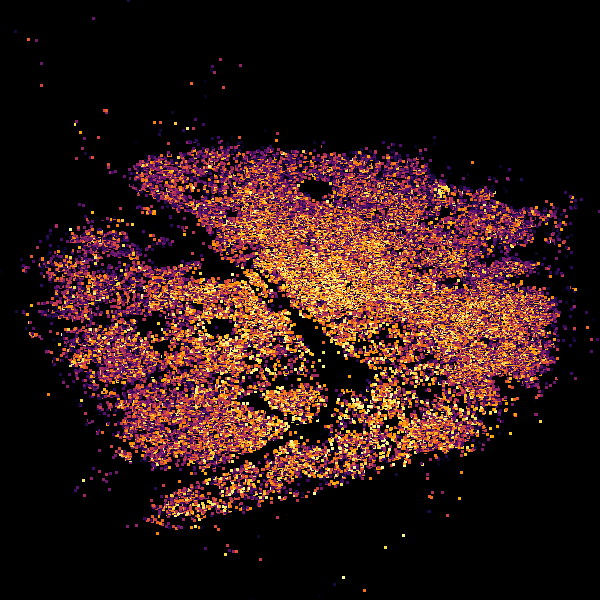
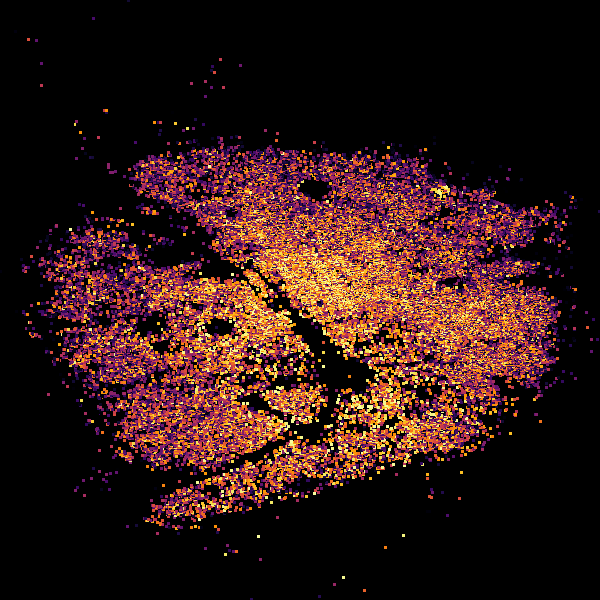
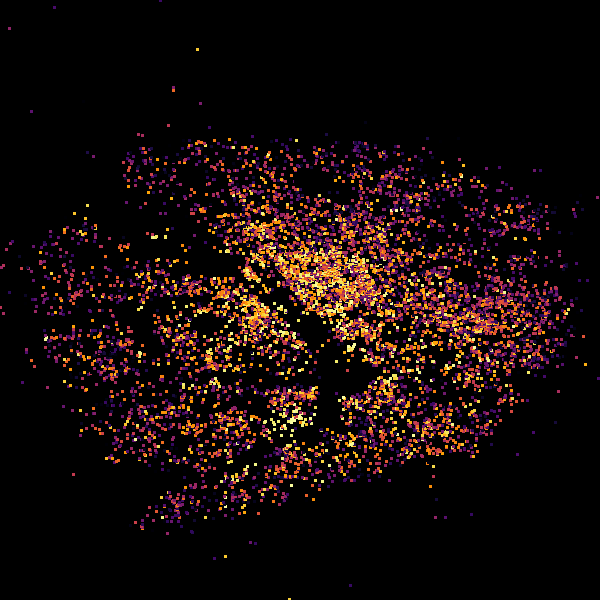

In [18]:
# Continuation - breakup of Illegal and Legal revenue from listings
tf.Images(tf.set_background(tf.dynspread(tf.shade(agg_IR_IL, cmap=inferno, \
                                         name='Illegal revenue from Illegal Listings')),"black"),\
          tf.set_background(tf.dynspread(tf.shade(agg_LR_IL, cmap=inferno, \
                                         name='Legal revenue from Illegal Listings')),"black"),\
          tf.set_background(tf.dynspread(tf.shade(agg_LR_LL, cmap=inferno, \
                                         name='Legal revenue from Legal Listings')),"black"))

# Interactive plots with background map of Paris

In [19]:
# Find the latitude and longitude range for further plotting
print("Min values:\n", Booked[["longitude", "latitude"]].min())
print("Max values:\n", Booked[["longitude", "latitude"]].max())

Min values:
 longitude     2.221442
latitude     48.812647
dtype: float64
Max values:
 longitude     2.473700
latitude     48.904884
dtype: float64


In [20]:
# Even though conventionally the geographical range is ((2.05, 2.65), (48.76, 48.97)), we will adjust to our dataset
PARIS = x_range,y_range = ds.utils.lnglat_to_meters((2.20, 2.49), (48.79, 48.92))
print (x_range,y_range)

[244902.8797452  277185.53207525] [6239303.61713774 6261297.95340785]


In [21]:
output_notebook()

plot_width  = int(450)
plot_height = int(plot_width//1.2)

def base_plot(tools='pan,wheel_zoom,reset',plot_width=plot_width, plot_height=plot_height, **plot_args):
    p = figure(tools=tools, plot_width=plot_width, plot_height=plot_height,
        x_range=x_range, y_range=y_range, outline_line_color=None,
        min_border=0, min_border_left=0, min_border_right=0,
        min_border_top=0, min_border_bottom=0, **plot_args)
    
    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    
    p.add_tools(BoxZoomTool(match_aspect=True))
    
    return p

def merged_images (x_range, y_range,w=plot_width, h=plot_height, how='log'):
    a= Legal.Legal_revenue
    b=Illegal.Illegal_revenue
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    Legal_pt = cvs.points(Legal, 'long',  'lat')
    Illegal_pt = cvs.points(Illegal, 'long', 'lat')
    Legal_pt = Legal_pt.rename({'long': 'x', 'lat': 'y'})
    Illegal_pt = Illegal_pt.rename({'long': 'x', 'lat': 'y'})
    more_legal = tf.shade(Legal_pt.where(Legal_pt > Illegal_pt), cmap=["blue", 'cornflowerblue'], how=how)
    more_illegal = tf.shade(Illegal_pt.where(Illegal_pt > Legal_pt), cmap=["darkred", 'orangered'], how=how)
    img = tf.stack(more_legal, more_illegal)
    return tf.dynspread(img, threshold=0.3, max_px=4)

merged_images

Loading BokehJS ...

<function __main__.merged_images(x_range, y_range, w=450, h=375, how='log')>

In [23]:
# Distribution with all listing irrespective of legality
options = dict(line_color=None, fill_color='blue', size=2, alpha=0.5)

b = base_plot()
b.add_tile(STAMEN_TERRAIN)
b.circle(x=Booked['long'], y=Booked['lat'], **options)
b.title.text = "All listings"
b.title.text_color = "black"
b.title.text_font_size = "20px"

# Legal listings
options = dict(line_color=None, fill_color='blue', size=2, alpha=0.5)

c = base_plot()
c.add_tile(STAMEN_TERRAIN)
c.circle(x=Legal['long'], y=Legal['lat'], **options)
c.title.text = "Legal listings"
c.title.text_color = "black"
c.title.text_font_size = "20px"

# Illegal listings
options = dict(line_color=None, fill_color='blue', size=2, alpha=0.5)

d = base_plot()
d.add_tile(STAMEN_TERRAIN)
d.circle(x=Illegal['long'], y=Illegal['lat'], **options)
d.title.text = "Illegal listings"
d.title.text_color = "black"
d.title.text_font_size = "20px"

# legal and illegal listings
e = base_plot()
e.add_tile(STAMEN_TERRAIN) 
e.title.text = 'Illegal (in red) and legal (in blue) listings'
e.title.text_color = "black"
e.title.text_font_size = "20px"
InteractiveImage(e, merged_images) 


# We can use gridplot from layouts too. However, layout function can arrange both plots and widgets in a grid.
l = layout([
  [b, e],
  [c, d],
])



##### Insights & Recommendations -

Illegal days and Illegal listings are an enormous revenue generator for Airbnb. Moreover, a massive share of legal revenue comes from illegal listings that eventually surpass the limit. As a result, a fine or possible legal action, such as total debarment of illegal entities, could have a mammoth impact on the business in Paris. Immediate internal restriction is recommended. 

As shown below, Illegal listings have a massive share of the legal revenue. 

In [24]:
show(l)